In [6]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile

## Unzipping

In [18]:
    folder_path = os.path.join("..", "data", "asl_alphabet_train") # Path to the data if unzipped already
    if not os.path.exists(folder_path): # Checking to see if folder is unzipped
        print("Unzipping file")
        path_to_zip = os.path.join("..","data","archive1.zip") # Defining the path to the zip file
        zip_destination = os.path.join("..", "data") # defining the output destination

        with zipfile.ZipFile(path_to_zip,"r") as zip_ref: # using the package from zipfile, to un zip the zip file
            zip_ref.extractall(zip_destination)
    print("The files are unzipped")

Unzipping file
The files are unzipped


## Train and validation generator 

In [19]:

    print("Creating Image data generator")
    # ImageDataGenerator from tensorflow 
    datagen = ImageDataGenerator(horizontal_flip=True,
                                validation_split = 0.2, # Flip it horizontally around the access randomly 
                                 # Rotate the image randomly 20 degress around the access
                                rescale = 1/255 # rescale the pixel values to between 0-1
                                
    )


Creating Image data generator


In [20]:
directory = os.path.join("..","data","asl_alphabet_train", "asl_alphabet_train")

In [22]:
training_tensorflow = datagen.flow_from_directory(
    directory,
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    #save_to_dir=None,
    #save_prefix='',
    #save_format='png',
    #follow_links=False,
    subset="training",
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 62400 images belonging to 26 classes.


In [24]:
validation_tensorflow = datagen.flow_from_directory(
    directory,
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    #save_to_dir=None,
    #save_prefix='',
    #save_format='png',
    #follow_links=False,
    subset="validation",
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 15600 images belonging to 26 classes.


## Test images

In [ ]:
directory_test = os.path.join("..","data","asl_alphabet_test", "asl_alphabet_test")

In [34]:
test_df = pd.DataFrame()
test_df['filename'] = os.listdir(directory_test)
test_df['label'] = test_df['filename'].apply(lambda x: x.split('_')[0]) # Assumes file names are in the format 'label.extension'


In [35]:
test_df

,filename,label
0,C_test.jpg,C
1,W_test.jpg,W
2,A_test.jpg,A
3,V_test.jpg,V
4,T_test.jpg,T
5,E_test.jpg,E
6,Y_test.jpg,Y
7,R_test.jpg,R
8,X_test.jpg,X
9,N_test.jpg,N


In [50]:
    test_datagen = ImageDataGenerator(                 
                                    rescale = 1./255. # Datagenerator for test, it only has to rescale the images 
    )

In [51]:
test_tensorflow_ = test_datagen.flow_from_dataframe(
    test_df,
    directory=directory_test,
    x_col='filename',
    y_col='label',
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=None,
    interpolation='nearest',
    keep_aspect_ratio=False
)

#["A","B","C","D","E","F","G","H","J","K","L","M","N","P","Q","R","S","T","U","V","W","X","Y","Z"],

Found 26 validated image filenames belonging to 26 classes.


In [39]:

    print("Loading model: ")  
    # load model without classifier layers
    model = VGG16(include_top=False, # Exclude classifier layers
                pooling='avg',
                input_shape=(90, 90, 3)) # Input shape of the images. 224 pixels by 224. 3 color channels

    # Keep pretrained layers, and don't modify them
    for layer in model.layers:
        layer.trainable = False
        
    # Add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    bn = BatchNormalization()(flat1) # Added batnormalization from tensorflow. Take the previouslayer, normalise the values, and than pass them on
    class1 = Dense(256, 
                activation='relu')(bn) # Added new classification layer 
    class2 = Dense(128, 
                activation='relu')(class1) # Added new classification layer with 15 outputs. 15 labels in total
    output = Dense(26, # 15 labels
                activation='softmax')(class2)

    # define new model
    model = Model(inputs=model.inputs, 
                outputs=output)

    # compile
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, # Start learning rate at 0.01
        decay_steps=10000, # Every 10 000 steps start decaying 
        decay_rate=0.9) # DEcay by 0.9 to the start learning rate
    sgd = SGD(learning_rate=lr_schedule)

    model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # summarize
    print(model.summary())
    

Loading model: 
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 90, 90, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 90, 90, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 45, 45, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 45, 45, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 45, 45, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 22, 22,

In [40]:
    H = model.fit( # fitting the model to 
        training_tensorflow, # training data from tensorflow dataframe 
        steps_per_epoch = len(training_tensorflow), # Take as many steps as the length of the dataframe 
        validation_data = validation_tensorflow, # Validation data from tensorflow dataframe
        validation_steps = len(validation_tensorflow), # Validation steps as length of validation data 
        epochs = 2)

Epoch 1/2


2023-05-12 13:50:30.169904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1950/1950 [==============================] - ETA: 0s - loss: 1.2653 - accuracy: 0.6813

2023-05-12 14:05:08.351889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1950/1950 [==============================] - 1088s 558ms/step - loss: 1.2653 - accuracy: 0.6813 - val_loss: 1.1473 - val_accuracy: 0.6602
Epoch 2/2
1950/1950 [==============================] - 761s 390ms/step - loss: 0.3508 - accuracy: 0.9090 - val_loss: 0.9614 - val_accuracy: 0.7128


## Predictions

In [53]:
    pred = model.predict(test_tensorflow_) # Using test data on the model
    pred = np.argmax(pred,axis=1)

    # Map the label 
    labels = (training_tensorflow.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

2023-05-12 14:25:34.508111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 275ms/step


## Classifier report

In [54]:
    y_true = test_df['label'].values # Test labels from dataframe
    classification_report_test = classification_report(y_true, pred) # Create classification report with labels, and predictions
    print("Classification Report - Test Data:")
    print(classification_report_test)

Classification Report - Test Data:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00   

/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Plotting history 

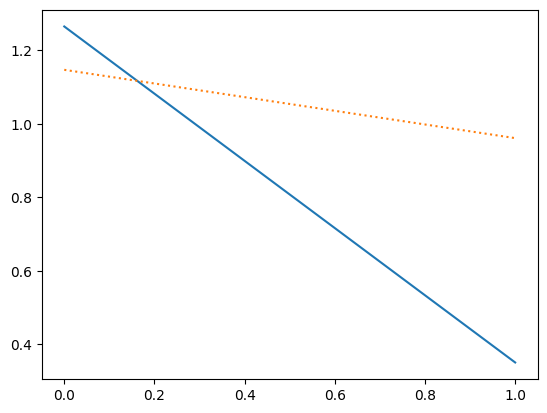

In [59]:
plt.plot(np.arange(0,2), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, 2), H.history["val_loss"], label="val_loss", linestyle=":")